Please upload your CSV dataset.


Saving instagram_dataset.csv to instagram_dataset (7).csv

Training Standard DNN...

Training Robust DNN...


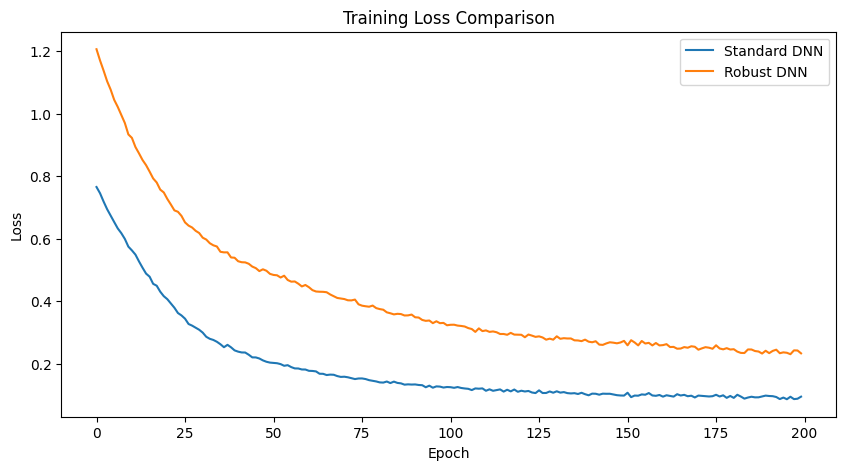


=== Standard DNN Evaluation ===

=== Standard DNN - Clean ===
              precision    recall  f1-score   support

        Real       0.39      0.96      0.56        28
        Fake       0.99      0.80      0.89       208

    accuracy                           0.82       236
   macro avg       0.69      0.88      0.72       236
weighted avg       0.92      0.82      0.85       236



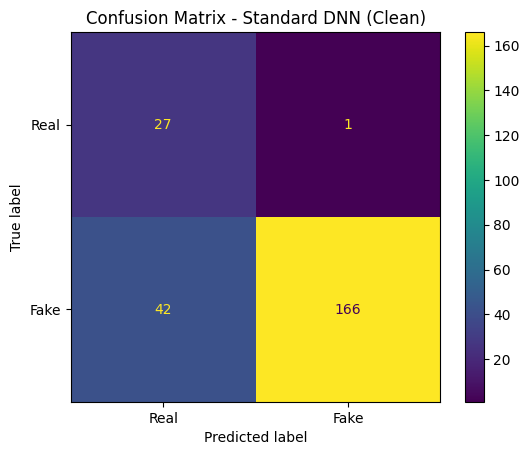

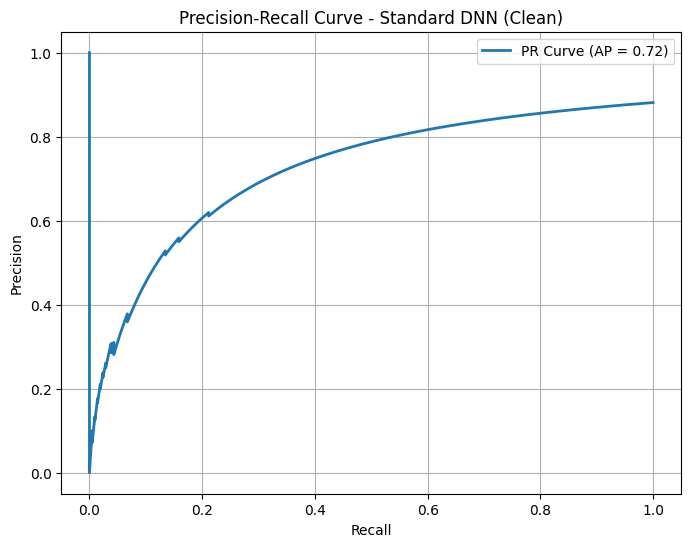


=== Standard DNN - FGSM ===
              precision    recall  f1-score   support

        Real       0.62      0.57      0.59        28
        Fake       0.94      0.95      0.95       208

    accuracy                           0.91       236
   macro avg       0.78      0.76      0.77       236
weighted avg       0.90      0.91      0.91       236



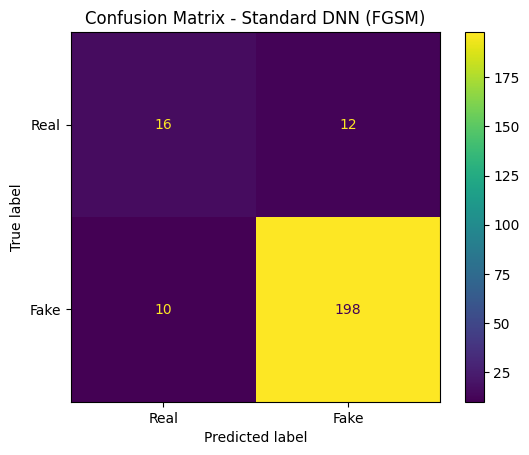

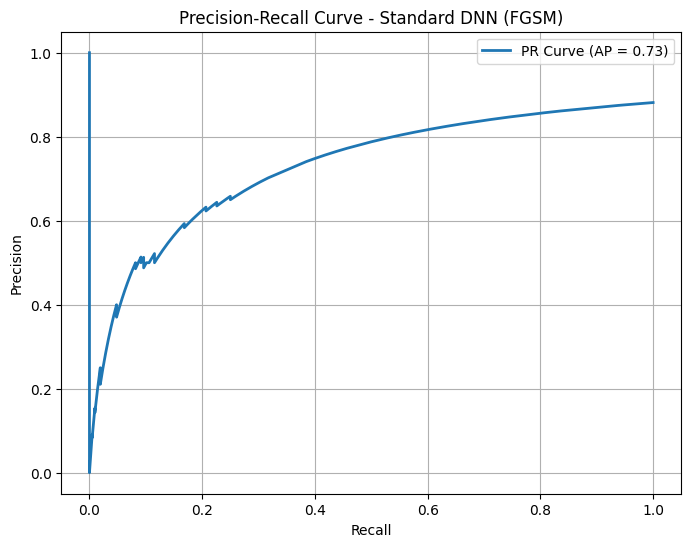


=== Standard DNN - PGD ===
              precision    recall  f1-score   support

        Real       0.62      0.57      0.59        28
        Fake       0.94      0.95      0.95       208

    accuracy                           0.91       236
   macro avg       0.78      0.76      0.77       236
weighted avg       0.90      0.91      0.91       236



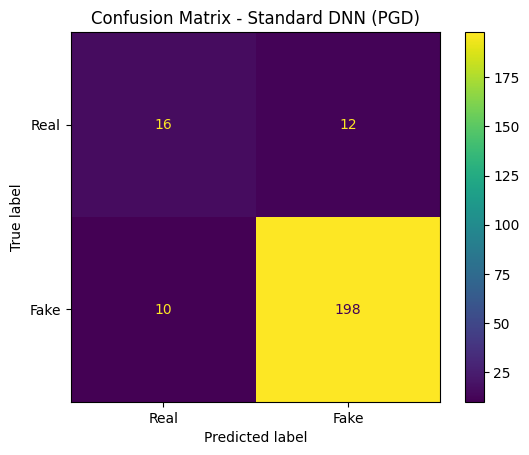

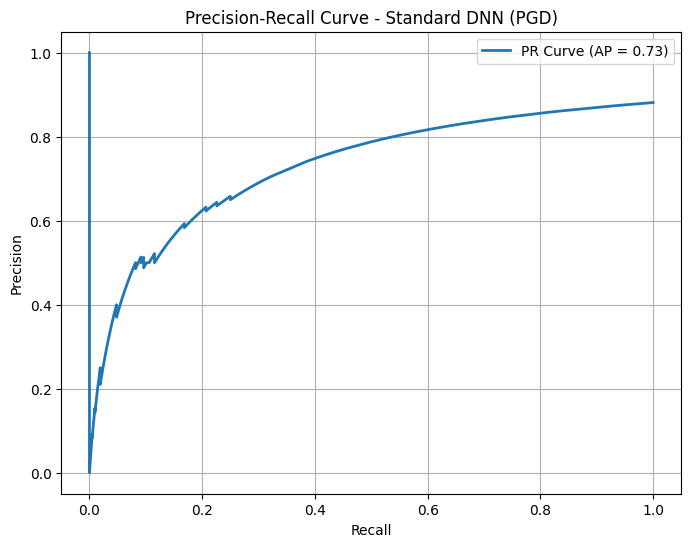


=== Standard DNN - CW ===
              precision    recall  f1-score   support

        Real       0.28      0.57      0.37        28
        Fake       0.93      0.80      0.86       208

    accuracy                           0.77       236
   macro avg       0.60      0.68      0.62       236
weighted avg       0.85      0.77      0.80       236



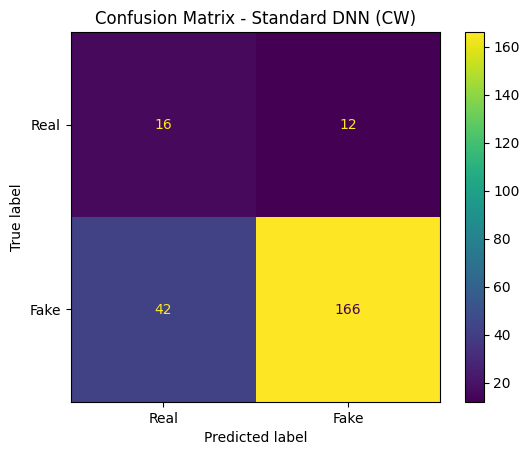

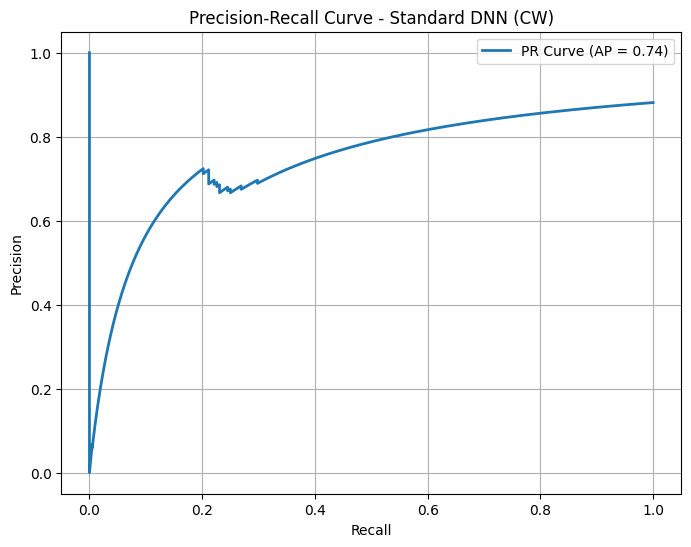


=== Robust DNN Evaluation ===

=== Robust DNN - Clean ===
              precision    recall  f1-score   support

        Real       0.38      1.00      0.55        28
        Fake       1.00      0.78      0.88       208

    accuracy                           0.81       236
   macro avg       0.69      0.89      0.72       236
weighted avg       0.93      0.81      0.84       236



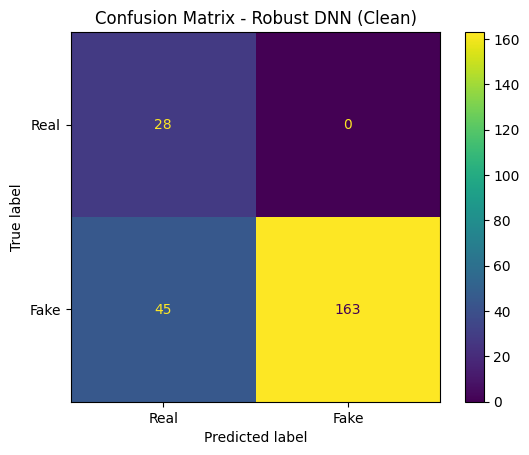

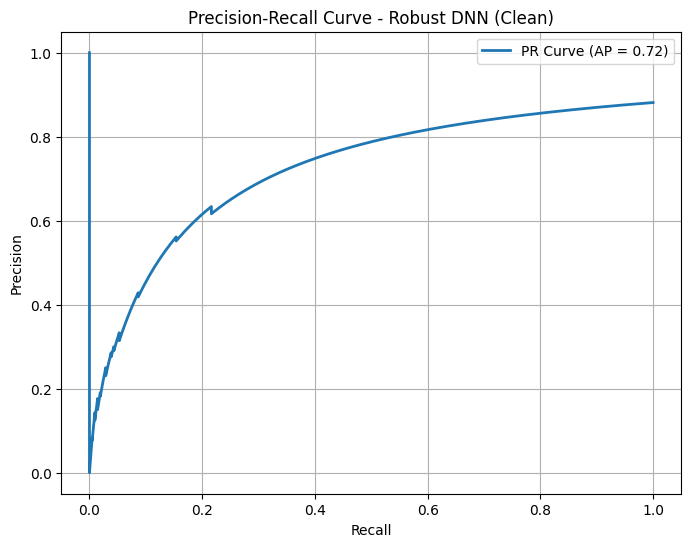


=== Robust DNN - FGSM ===
              precision    recall  f1-score   support

        Real       0.34      1.00      0.50        28
        Fake       1.00      0.74      0.85       208

    accuracy                           0.77       236
   macro avg       0.67      0.87      0.68       236
weighted avg       0.92      0.77      0.81       236



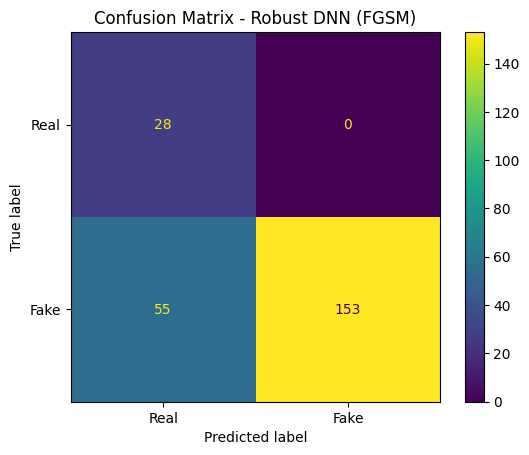

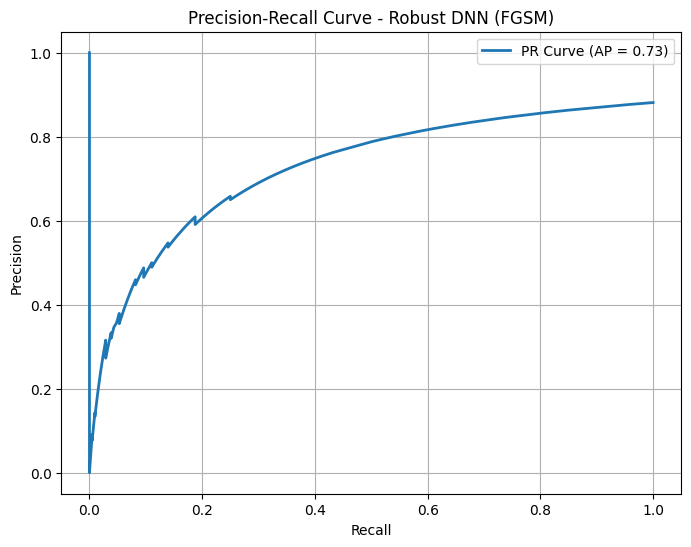


=== Robust DNN - PGD ===
              precision    recall  f1-score   support

        Real       0.34      1.00      0.50        28
        Fake       1.00      0.74      0.85       208

    accuracy                           0.77       236
   macro avg       0.67      0.87      0.68       236
weighted avg       0.92      0.77      0.81       236



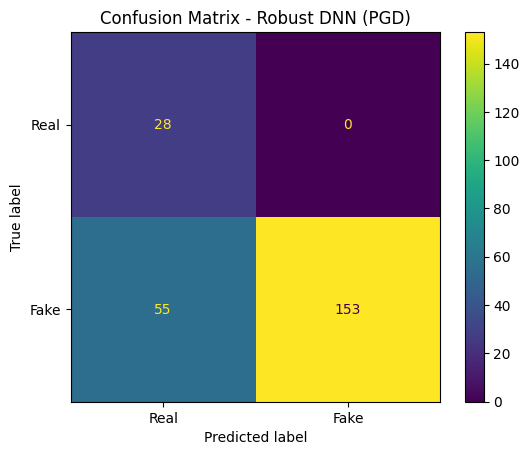

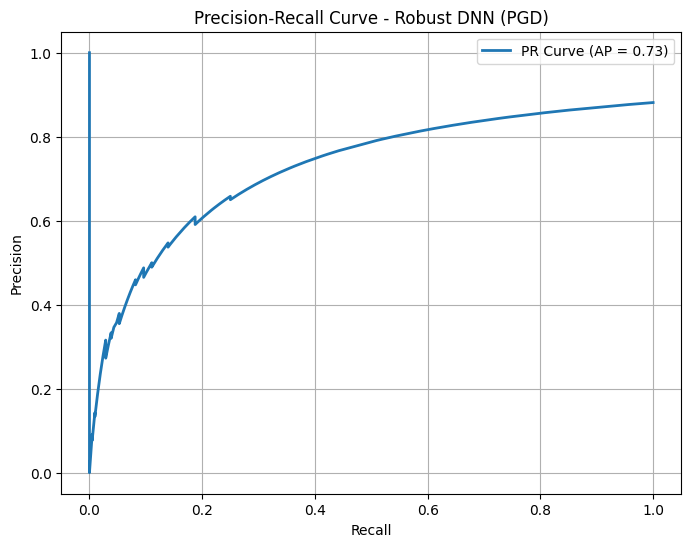


=== Robust DNN - CW ===
              precision    recall  f1-score   support

        Real       0.26      0.96      0.41        28
        Fake       0.99      0.63      0.77       208

    accuracy                           0.67       236
   macro avg       0.63      0.80      0.59       236
weighted avg       0.91      0.67      0.73       236



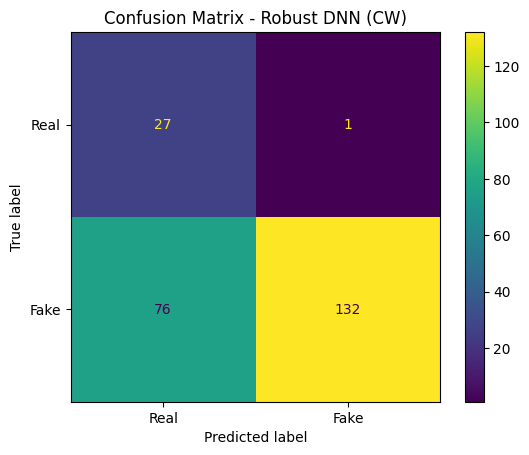

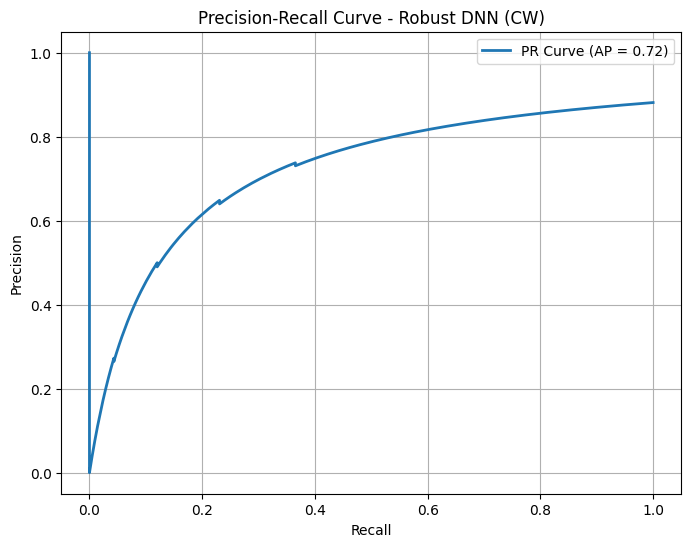


=== Comparative Robustness Analysis ===


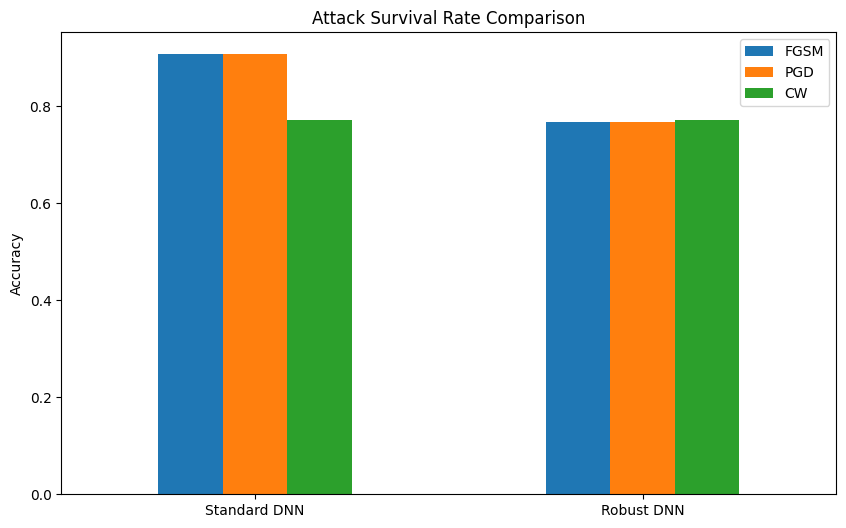

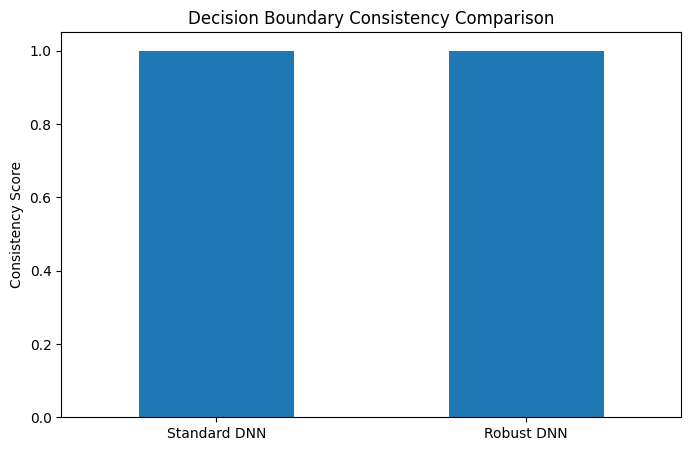

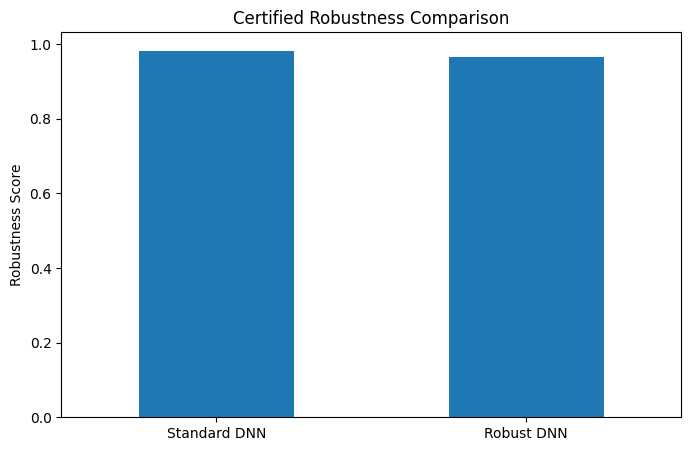

                                           Attack Survival Rate  \
Standard DNN  {'FGSM': 0.9067796468734741, 'PGD': 0.90677964...   
Robust DNN    {'FGSM': 0.7669491767883301, 'PGD': 0.76694917...   

             Boundary Consistency Certified Robustness  
Standard DNN                  1.0             0.983051  
Robust DNN                    1.0             0.966102  


In [9]:
# Install necessary packages
!pip install torchattacks numpy pandas scikit-learn torch matplotlib seaborn imbalanced-learn

# Import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, balanced_accuracy_score,
                             f1_score, precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import torchattacks
from imblearn.over_sampling import SMOTE
from google.colab import files
import warnings
warnings.filterwarnings("ignore")
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark=False

# Data Preparation Function
def prepare_data(df):
    """Prepare dataset with stratification and return class weights"""
    df = df.drop(['has_channel', 'has_guides'], axis=1, errors='ignore')
    features = ['edge_followed_by', 'edge_follow', 'username_length', 'username_has_number',
                'full_name_has_number', 'full_name_length', 'is_private', 'is_joined_recently',
                'is_business_account', 'has_external_url']
    X = df[features].values
    y = df['is_fake'].values

    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # Calculate class weights
    class_counts = np.bincount(y_train)
    class_weights = 1. / class_counts
    class_weights = torch.FloatTensor(class_weights / class_weights.sum())

    # Preprocessing
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Convert to tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_test = torch.LongTensor(y_test)

    return X_train, X_test, y_train, y_test, class_weights

# DNN Model
class DNN(nn.Module):
    def __init__(self, input_size):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.layers(x)

# Robustness Analysis Tools
class AdversarialExposure:
    """Evaluates model against known attack methods"""
    def __init__(self, attack_params):
        self.attack_params = attack_params

    def evaluate(self, model, X, y):
        results = {}
        attacks = {
            'FGSM': torchattacks.FGSM(model, eps=self.attack_params['eps']),
            'PGD': torchattacks.PGD(model,
                                  eps=self.attack_params['eps'],
                                  alpha=self.attack_params['alpha'],
                                  steps=self.attack_params['steps']),
            'CW': torchattacks.CW(model,
                                c=self.attack_params['c'],
                                steps=self.attack_params['steps'])
        }

        for name, attack in attacks.items():
            X_adv = attack(X.clone(), y.clone())
            with torch.no_grad():
                outputs = model(X_adv)
                acc = (outputs.argmax(1) == y).float().mean()
            results[name] = acc.item()
        return results

class BoundarySensitivityAnalyzer:
    """Analyzes decision boundary stability"""
    def __init__(self, n_samples=100, eps=0.1):
        self.n_samples = n_samples
        self.eps = eps

    def analyze(self, model, X):
        perturbations = torch.randn(self.n_samples, *X.shape) * self.eps
        decisions = []
        for pert in perturbations:
            with torch.no_grad():
                outputs = model(X + pert)
                decisions.append(outputs.argmax(1))
        consistency = (torch.stack(decisions) == decisions[0]).float().mean()
        return consistency.item()

class CertifiedRobustnessVerifier:
    """Provides theoretical robustness guarantees"""
    def __init__(self, radius=0.1):
        self.radius = radius

    def verify(self, model, X, y):
        with torch.no_grad():
            base_pred = model(X).argmax(1)
        perturbed = X + torch.randn_like(X) * self.radius
        with torch.no_grad():
            perturbed_pred = model(perturbed).argmax(1)
        cert_acc = (base_pred == perturbed_pred).float().mean()
        return cert_acc.item()

# Model Training Functions
def train_standard_dnn(X_train, y_train, class_weights):
    model = DNN(X_train.shape[1])
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 200
    loss_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return model, loss_history

def train_robust_dnn(X_train, y_train, class_weights):
    model = DNN(X_train.shape[1])
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 200
    loss_history = []
    pgd = torchattacks.PGD(model, eps=0.05, alpha=0.01, steps=10)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Clean loss
        outputs_clean = model(X_train)
        loss_clean = criterion(outputs_clean, y_train)

        # Adversarial loss
        model.eval()
        X_adv = pgd(X_train, y_train)
        model.train()
        outputs_adv = model(X_adv)
        loss_adv = criterion(outputs_adv, y_train)

        total_loss = loss_clean + loss_adv
        total_loss.backward()
        optimizer.step()
        loss_history.append(total_loss.item())

    return model, loss_history

# Enhanced Evaluation Function
def full_evaluation(model, X_test, y_test, model_name):
    """Comprehensive evaluation with all visualizations"""
    model.eval()
    results = {}
    probs_dict = {}

    # Clean data evaluation
    with torch.no_grad():
        outputs = model(X_test)
        probs = torch.softmax(outputs, dim=1)[:, 0].numpy()
        _, y_pred = torch.max(outputs, 1)
        results['Clean'] = y_pred
        probs_dict['Clean'] = probs

    # Configure attacks
    attacks = {
        'FGSM': torchattacks.FGSM(model, eps=0.05),
        'PGD': torchattacks.PGD(model, eps=0.05, alpha=0.01, steps=10),
        'CW': torchattacks.CW(model, c=1, steps=100, lr=0.02)
    }

    # Generate adversarial examples
    for name, attack in attacks.items():
        X_adv = attack(X_test.clone(), y_test.clone())
        with torch.no_grad():
            outputs_adv = model(X_adv)
            probs_adv = torch.softmax(outputs_adv, dim=1)[:, 0].numpy()
            _, y_pred_adv = torch.max(outputs_adv, 1)
            results[name] = y_pred_adv
            probs_dict[name] = probs_adv

    # Generate reports and plots
    y_test_np = y_test.numpy()
    for scenario, preds in results.items():
        preds_np = preds.numpy()
        print(f"\n=== {model_name} - {scenario} ===")
        print(classification_report(y_test_np, preds_np, target_names=['Real', 'Fake']))

        # Confusion Matrix
        cm = confusion_matrix(y_test_np, preds_np)
        disp = ConfusionMatrixDisplay(cm, display_labels=['Real', 'Fake'])
        disp.plot()
        plt.title(f"Confusion Matrix - {model_name} ({scenario})")
        plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test_np, probs_dict[scenario])
        avg_precision = average_precision_score(y_test_np, probs_dict[scenario])

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, lw=2,
                label=f'PR Curve (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name} ({scenario})')
        plt.legend()
        plt.grid(True)
        plt.show()

# Comparative Analysis
def comparative_analysis(models, X_test, y_test):
    """Generate comparative visualizations"""
    attack_params = {
        'eps': 0.05,
        'alpha': 0.01,
        'steps': 10,
        'c': 1
    }

    exposure = AdversarialExposure(attack_params)
    sensitivity_analyzer = BoundarySensitivityAnalyzer()
    robustness_verifier = CertifiedRobustnessVerifier()

    sample_idx = torch.randint(0, len(X_test), (1,)).item()
    sample_X = X_test[sample_idx].unsqueeze(0)

    results = {}
    for model_name, model in models.items():
        model.eval()

        # Adversarial Exposure
        attack_results = exposure.evaluate(model, X_test, y_test)

        # Boundary Sensitivity
        boundary_consistency = sensitivity_analyzer.analyze(model, sample_X)

        # Certified Robustness
        cert_robustness = robustness_verifier.verify(model, X_test, y_test)

        results[model_name] = {
            'Attack Survival Rate': attack_results,
            'Boundary Consistency': boundary_consistency,
            'Certified Robustness': cert_robustness
        }

    # Visualization 1: Attack Survival Rate
    attack_df = pd.DataFrame({k: v['Attack Survival Rate'] for k, v in results.items()}).T
    attack_df.plot.bar(figsize=(10, 6))
    plt.title('Attack Survival Rate Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=0)
    plt.show()

    # Visualization 2: Boundary Consistency
    boundary_df = pd.DataFrame({k: [v['Boundary Consistency']] for k, v in results.items()}).T
    boundary_df.columns = ['Consistency']
    boundary_df.plot.bar(legend=False, figsize=(8, 5))
    plt.title('Decision Boundary Consistency Comparison')
    plt.ylabel('Consistency Score')
    plt.xticks(rotation=0)
    plt.show()

    # Visualization 3: Certified Robustness
    cert_df = pd.DataFrame({k: [v['Certified Robustness']] for k, v in results.items()}).T
    cert_df.columns = ['Robustness']
    cert_df.plot.bar(legend=False, figsize=(8, 5))
    plt.title('Certified Robustness Comparison')
    plt.ylabel('Robustness Score')
    plt.xticks(rotation=0)
    plt.show()

    return pd.DataFrame(results).T

# Main Execution
print("Please upload your CSV dataset.")
uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])

# Prepare data
X_train, X_test, y_train, y_test, class_weights = prepare_data(df)

# Train models
print("\nTraining Standard DNN...")
standard_model, standard_loss = train_standard_dnn(X_train, y_train, class_weights)

print("\nTraining Robust DNN...")
robust_model, robust_loss = train_robust_dnn(X_train, y_train, class_weights)

# Training curves
plt.figure(figsize=(10, 5))
plt.plot(standard_loss, label='Standard DNN')
plt.plot(robust_loss, label='Robust DNN')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Full evaluations
print("\n=== Standard DNN Evaluation ===")
full_evaluation(standard_model, X_test, y_test, "Standard DNN")

print("\n=== Robust DNN Evaluation ===")
full_evaluation(robust_model, X_test, y_test, "Robust DNN")

# Comparative analysis
print("\n=== Comparative Robustness Analysis ===")
models = {'Standard DNN': standard_model, 'Robust DNN': robust_model}
comparison_results = comparative_analysis(models, X_test, y_test)
print(comparison_results)